In [ ]:
from google.colab import drive
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Create a folder for your results
output_folder = '/content/drive/My Drive/Simulations_Born_2D'
os.makedirs(output_folder, exist_ok=True)

print(f"📂 Results will be saved to: {output_folder}")

Mounted at /content/drive
📂 Les résultats seront sauvegardés dans : /content/drive/My Drive/Simulations_Born_2D


In [1]:
!pip install taichi scipy pandas matplotlib numba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00


[Taichi] Starting on arch=cuda
🚀 Starting : 10000 particles, N_Batch x Batch_size = 20 x 500


Total:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 1/20...


Current Batch:   0%|          | 0/400 [00:00<?, ?it/s]

Batch 2/20...


Current Batch:   0%|          | 0/400 [00:00<?, ?it/s]

Batch 3/20...


Current Batch:   0%|          | 0/400 [00:00<?, ?it/s]

Batch 4/20...


Current Batch:   0%|          | 0/400 [00:00<?, ?it/s]

Batch 5/20...


Current Batch:   0%|          | 0/400 [00:00<?, ?it/s]

Batch 6/20...


Current Batch:   0%|          | 0/400 [00:00<?, ?it/s]

Batch 7/20...


Current Batch:   0%|          | 0/400 [00:00<?, ?it/s]

Batch 8/20...


Current Batch:   0%|          | 0/400 [00:00<?, ?it/s]

Batch 9/20...


Current Batch:   0%|          | 0/400 [00:00<?, ?it/s]

Batch 10/20...


Current Batch:   0%|          | 0/400 [00:00<?, ?it/s]

Batch 11/20...


Current Batch:   0%|          | 0/400 [00:00<?, ?it/s]

Batch 12/20...


Current Batch:   0%|          | 0/400 [00:00<?, ?it/s]

Batch 13/20...


Current Batch:   0%|          | 0/400 [00:00<?, ?it/s]

Batch 14/20...


Current Batch:   0%|          | 0/400 [00:00<?, ?it/s]

Batch 15/20...


Current Batch:   0%|          | 0/400 [00:00<?, ?it/s]

Batch 16/20...


Current Batch:   0%|          | 0/400 [00:00<?, ?it/s]

Batch 17/20...


Current Batch:   0%|          | 0/400 [00:00<?, ?it/s]

Batch 18/20...


Current Batch:   0%|          | 0/400 [00:00<?, ?it/s]

Batch 19/20...


Current Batch:   0%|          | 0/400 [00:00<?, ?it/s]

Batch 20/20...


Current Batch:   0%|          | 0/400 [00:00<?, ?it/s]


📊 Processing data...


/tmp/ipython-input-1574880471.py:211: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  error_L1 = 0.5 * np.trapz(np.trapz(np.abs(rho - born), x_space, axis=0), y_space)
/tmp/ipython-input-1574880471.py:220: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Lz_mean = np.trapz(np.trapz(Lz_field * born, x_space, axis=0), y_space)



CONVERGENCE TOWARDS |ψ|²
Correlation ρ vs |ψ|²: 0.9954
L¹ Error: 0.053899
Quantum <Lz>: -0.000

💾 Graph saved : /content/drive/My Drive/Simulations_Born_2D/Born_2D_N10000_V1.png


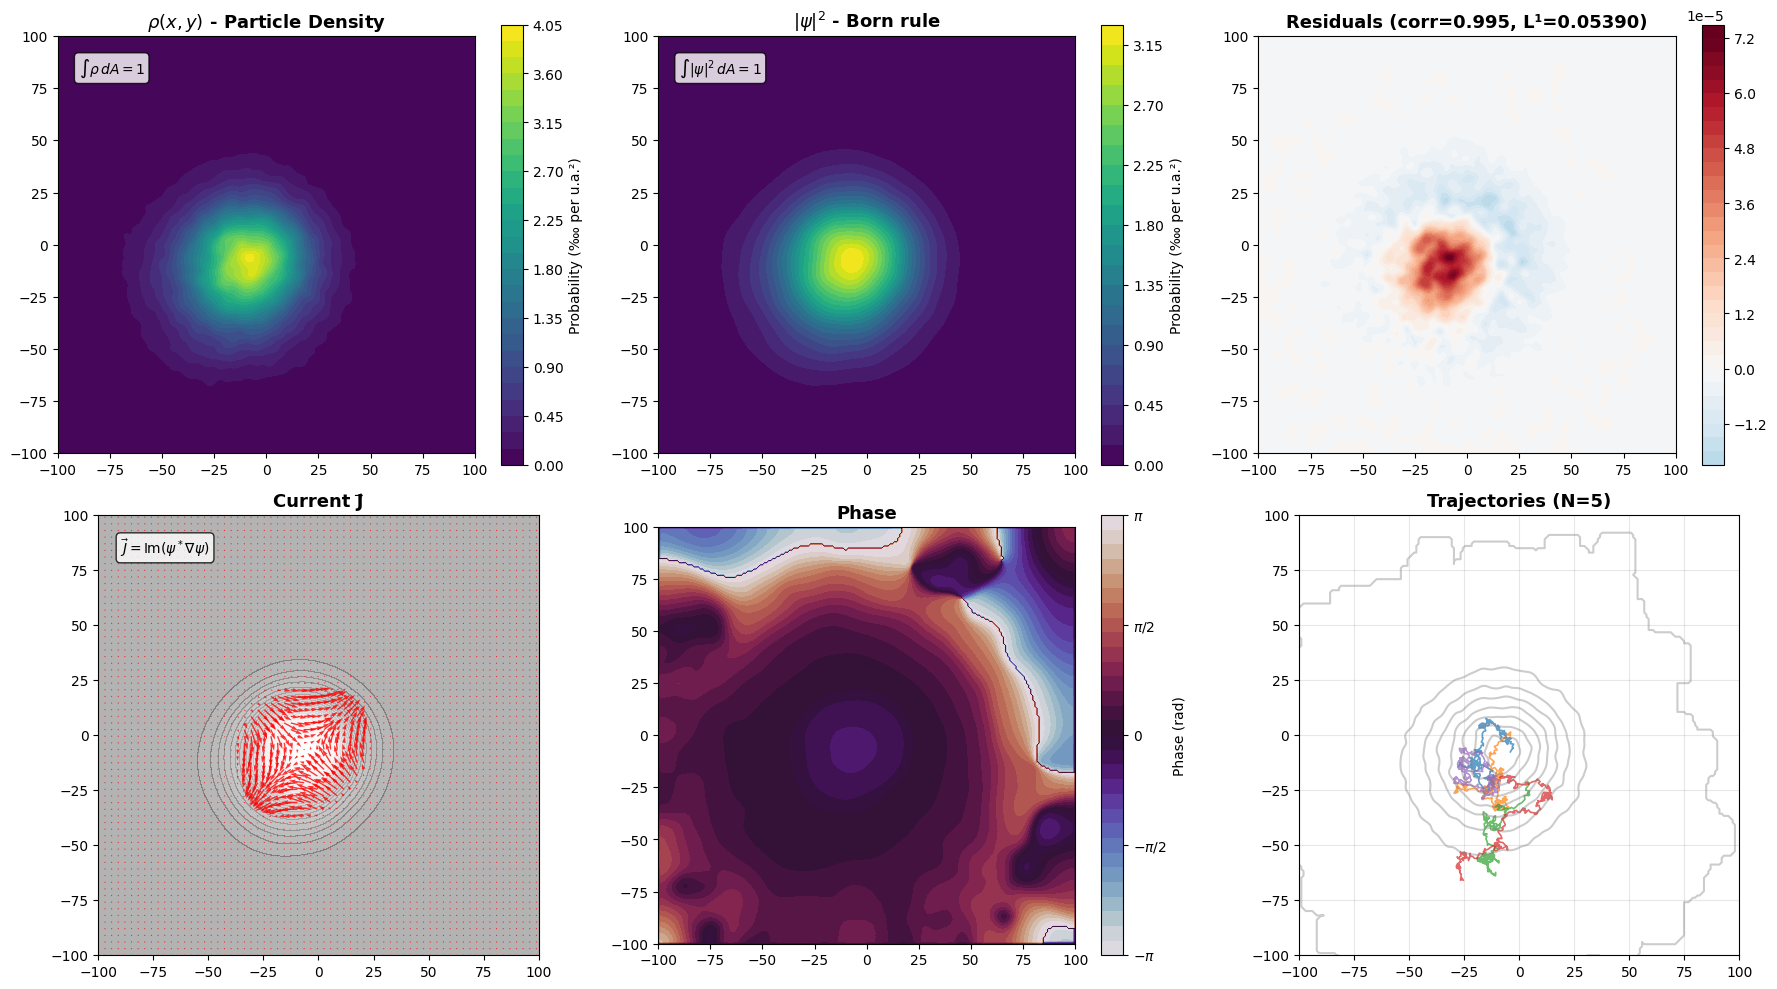

In [4]:
import taichi as ti
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm
import time
import os

# -------------------------------
# 1. INIT & CONFIG
# -------------------------------
ti.init(arch=ti.gpu, device_memory_GB=2.0)

# Spatial Parameters
Nx, Ny = 200, 200
x_min, x_max = -100, 100
y_min, y_max = -100, 100
dx = (x_max - x_min) / Nx
dy = (y_max - y_min) / Ny

# Simulation Parameters
N_TOTAL_RUNS = 10000
# high number = high statistical convergence = high correlation
# every 1000 Runs ≈ 10min

dt = 0.01
N_STEPS = 40000
THERMALIZATION = 10000
BATCH_SIZE = 500
N_BATCHES = max(1,round(N_TOTAL_RUNS // BATCH_SIZE))

# Physics Parameters
D_psi = 0.9
omega = 2.0
gamma = 0.045
alpha = 4.0
D_part = 0.28
emit_amp = 0.57
sigma_emit = dx*3
epsilon = 1e-4

# -------------------------------
# 2. TAICHI FIELDS (GPU)
# -------------------------------
# Dynamic Fields (Batch x Space)
psi_r = ti.field(ti.f32, shape=(BATCH_SIZE, Nx, Ny))
psi_i = ti.field(ti.f32, shape=(BATCH_SIZE, Nx, Ny))
psi_new_r = ti.field(ti.f32, shape=(BATCH_SIZE, Nx, Ny))
psi_new_i = ti.field(ti.f32, shape=(BATCH_SIZE, Nx, Ny))

# Laplacian Buffers
lap_r = ti.field(ti.f32, shape=(BATCH_SIZE, Nx, Ny))
lap_i = ti.field(ti.f32, shape=(BATCH_SIZE, Nx, Ny))

# Particles
px = ti.field(ti.f32, shape=BATCH_SIZE)
py = ti.field(ti.f32, shape=BATCH_SIZE)

# Global Accumulators
global_rho = ti.field(ti.f32, shape=(Nx, Ny))
global_psi2 = ti.field(ti.f32, shape=(Nx, Ny))
global_psi_r = ti.field(ti.f32, shape=(Nx, Ny))
global_psi_i = ti.field(ti.f32, shape=(Nx, Ny))

# -------------------------------
# 3. MODULAR KERNELS
# -------------------------------

@ti.kernel
def init_batch():
    for b, i, j in psi_r:
        psi_r[b, i, j] = 0
        psi_i[b, i, j] = 0
        psi_new_r[b, i, j] = 0
        psi_new_i[b, i, j] = 0

    for b in range(BATCH_SIZE):
        r = ti.random() * 5.0 + 5.0
        theta = ti.random() * 6.28318
        px[b] = r * ti.cos(theta)
        py[b] = r * ti.sin(theta)

@ti.kernel
def compute_laplacian():
    for b, i, j in ti.ndrange(BATCH_SIZE, (1, Nx-1), (1, Ny-1)):
        lap_r[b, i, j] = (psi_r[b, i+1, j] + psi_r[b, i-1, j] +
                          psi_r[b, i, j+1] + psi_r[b, i, j-1] - 4*psi_r[b, i, j]) / dx**2
        lap_i[b, i, j] = (psi_i[b, i+1, j] + psi_i[b, i-1, j] +
                          psi_i[b, i, j+1] + psi_i[b, i, j-1] - 4*psi_i[b, i, j]) / dx**2

@ti.kernel
def evolve_field():
    for b, i, j in ti.ndrange(BATCH_SIZE, (1, Nx-1), (1, Ny-1)):
        dr = D_psi * lap_r[b, i, j] - omega * lap_i[b, i, j] - gamma * psi_r[b, i, j]
        di = D_psi * lap_i[b, i, j] + omega * lap_r[b, i, j] - gamma * psi_i[b, i, j]

        psi_new_r[b, i, j] = psi_r[b, i, j] + dt * dr
        psi_new_i[b, i, j] = psi_i[b, i, j] + dt * di

@ti.kernel
def apply_source():
    # Parallelization on BATCH only to avoid race conditions
    cutoff = ti.cast(5 * sigma_emit / dx, ti.i32)

    for b in range(BATCH_SIZE):
        p_x, p_y = px[b], py[b]
        ix = ti.cast(ti.round((p_x - x_min) / dx, ti.i32))
        iy = ti.cast(ti.round((p_y - y_min) / dy, ti.i32))

        i_start = ti.max(1, ix - cutoff); i_end = ti.min(Nx-1, ix + cutoff)
        j_start = ti.max(1, iy - cutoff); j_end = ti.min(Ny-1, iy + cutoff)

        for i in range(i_start, i_end):
            for j in range(j_start, j_end):
                d2 = (x_min + i*dx - p_x)**2 + (y_min + j*dy - p_y)**2
                # We add to psi_new because it is the write buffer
                psi_new_r[b, i, j] += emit_amp * ti.exp(-0.5 * d2 / sigma_emit**2) * dt

@ti.kernel
def swap_fields():
    for b, i, j in ti.ndrange(BATCH_SIZE, Nx, Ny):
        psi_r[b, i, j] = psi_new_r[b, i, j]
        psi_i[b, i, j] = psi_new_i[b, i, j]

"""
@ti.kernel
def normalize_field():
    for b in range(BATCH_SIZE):
        norm2 = 0.0
        for i, j in ti.ndrange(Nx, Ny):
            norm2 += psi_r[b, i, j]**2 + psi_i[b, i, j]**2

        norm = ti.sqrt(norm2 * dx * dy)

        if norm > 10.0:
            factor = 10.0 / norm
            for i, j in ti.ndrange(Nx, Ny):
                psi_r[b, i, j] *= factor
                psi_i[b, i, j] *= factor
"""

@ti.kernel
def update_particles():
    for b in range(BATCH_SIZE):
        p_x, p_y = px[b], py[b]
        ix = ti.cast(ti.round((p_x - x_min) / dx, ti.i32))
        iy = ti.cast(ti.round((p_y - y_min) / dy, ti.i32))

        dx_val, dy_val = 0.0, 0.0

        if 1 <= ix < Nx-2 and 1 <= iy < Ny-2:
            amp2 = psi_r[b, ix, iy]**2 + psi_i[b, ix, iy]**2
            if amp2 > epsilon**2:
                # Phase Gradient (Manual calculation to avoid func calls)
                d_psi_r_dx = (psi_r[b, ix+1, iy] - psi_r[b, ix-1, iy]) / (2*dx)
                d_psi_i_dx = (psi_i[b, ix+1, iy] - psi_i[b, ix-1, iy]) / (2*dx)
                d_psi_r_dy = (psi_r[b, ix, iy+1] - psi_r[b, ix, iy-1]) / (2*dy)
                d_psi_i_dy = (psi_i[b, ix, iy+1] - psi_i[b, ix, iy-1]) / (2*dy)

                grad_phi_x = (psi_r[b, ix, iy] * d_psi_i_dx - psi_i[b, ix, iy] * d_psi_r_dx) / amp2
                grad_phi_y = (psi_r[b, ix, iy] * d_psi_i_dy - psi_i[b, ix, iy] * d_psi_r_dy) / amp2

                weight = amp2 / (amp2 + epsilon**2)
                dx_val = alpha * weight * grad_phi_x
                dy_val = alpha * weight * grad_phi_y

                # Clipping for stability
                dx_val = ti.max(ti.min(alpha * grad_phi_x, 10.0), -10.0)
                dy_val = ti.max(ti.min(alpha * grad_phi_y, 10.0), -10.0)

        px[b] += dx_val * dt + ti.randn() * ti.sqrt(2 * D_part * dt)
        py[b] += dy_val * dt + ti.randn() * ti.sqrt(2 * D_part * dt)

        # Boundaries
        if px[b] < x_min + 2*dx:
            px[b] = x_min + 2*dx
        elif px[b] > x_max - 2*dx:
            px[b] = x_max - 2*dx

        if py[b] < y_min + 2*dy:
            py[b] = y_min + 2*dy
        elif py[b] > y_max - 2*dy:
            py[b] = y_max - 2*dy

@ti.kernel
def accumulate_stats():
    # 1. Particle Density
    for b in range(BATCH_SIZE):
        idx_x = ti.cast((px[b] - x_min) / dx, ti.i32)
        idx_y = ti.cast((py[b] - y_min) / dy, ti.i32)
        if 0 <= idx_x < Nx and 0 <= idx_y < Ny:
            ti.atomic_add(global_rho[idx_x, idx_y], 1.0)

    # 2. Mean Fields (for Born and Phase)
    for b, i, j in psi_r:
        amp2 = psi_r[b, i, j]**2 + psi_i[b, i, j]**2
        ti.atomic_add(global_psi2[i, j], amp2)
        ti.atomic_add(global_psi_r[i, j], psi_r[b, i, j])
        ti.atomic_add(global_psi_i[i, j], psi_i[b, i, j])

# -------------------------------
# 4. ANALYSIS FUNCTION
# -------------------------------

def analyze_and_plot(X, Y, x_space, y_space, rho, born, psi_eff, trajectories):
    # Correlation
    mask = (rho > 1e-6) & (born > 1e-6)
    corr = np.corrcoef(rho[mask], born[mask])[0,1] if np.sum(mask) > 100 else 0.0

    # L1 Error
    error_L1 = 0.5 * np.trapz(np.trapz(np.abs(rho - born), x_space, axis=0), y_space)

    # Current
    grad_y, grad_x = np.gradient(psi_eff)
    J_x = np.imag(np.conj(psi_eff) * grad_x)
    J_y = np.imag(np.conj(psi_eff) * grad_y)

    # Angular Momentum
    Lz_field = X * J_y - Y * J_x
    Lz_mean = np.trapz(np.trapz(Lz_field * born, x_space, axis=0), y_space)

    print(f"\n{'='*70}")
    print(f"CONVERGENCE TOWARDS |ψ|²")
    print(f"{'='*70}")
    print(f"Correlation ρ vs |ψ|²: {corr:.4f}")
    print(f"L¹ Error: {error_L1:.6f}")
    print(f"Quantum <Lz>: {Lz_mean:.3f}")

    # Visualization
    fig = plt.figure(figsize=(18, 10))

    # 1. Particle Density
    ax1 = plt.subplot(2, 3, 1)
    im1 = ax1.contourf(X, Y, rho*10000, levels=30, cmap='viridis')
    ax1.set_title(r'$\rho(x,y)$ - Particle Density', fontsize=13, fontweight='bold')
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('Probability (‱ per u.a.²)', fontsize=10)
    ax1.set_aspect('equal')
    ax1.text(0.05, 0.95, r'$\int \rho \, dA = 1$',
             transform=ax1.transAxes, fontsize=10, va='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 2. Born rule
    ax2 = plt.subplot(2, 3, 2)
    im2 = ax2.contourf(X, Y, born*10000, levels=30, cmap='viridis')
    ax2.set_title(r'$|\psi|^2$ - Born rule', fontsize=13, fontweight='bold')
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_label('Probability (‱ per u.a.²)', fontsize=10)
    ax2.set_aspect('equal')
    ax2.text(0.05, 0.95, r'$\int |\psi|^2 \, dA = 1$',
             transform=ax2.transAxes, fontsize=10, va='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 3. Difference (Residuals)
    ax3 = plt.subplot(2, 3, 3)
    diff = rho - born
    vmax = max(np.max(np.abs(diff)), 1e-6)
    im3 = ax3.contourf(X, Y, diff, levels=30, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    ax3.set_title(f'Residuals (corr={corr:.3f}, L¹={error_L1:.5f})', fontsize=13, fontweight='bold')
    plt.colorbar(im3, ax=ax3)
    ax3.set_aspect('equal')

    # 4. Flux (Current)
    ax4 = plt.subplot(2, 3, 4)
    step = 3
    ax4.contourf(X, Y, np.abs(psi_eff)**2, levels=20, cmap='gray', alpha=0.3)
    J_norm = np.sqrt(J_x**2 + J_y**2)
    max_J = np.max(J_norm) if np.max(J_norm) > 0 else 1.0
    ax4.quiver(X[::step, ::step], Y[::step, ::step],
               J_x[::step, ::step], J_y[::step, ::step],
               color='red', alpha=0.8, scale=max_J*20, width=0.003)
    ax4.set_title('Current J⃗', fontsize=13, fontweight='bold')
    ax4.set_aspect('equal')
    ax4.text(0.05, 0.95, r'$\vec{J} = \mathrm{Im}(\psi^* \nabla \psi)$',
             transform=ax4.transAxes, fontsize=10, va='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 5. Phase
    ax5 = plt.subplot(2, 3, 5)
    im5 = ax5.contourf(X, Y, np.angle(psi_eff)/np.pi, levels=np.linspace(-1, 1, 31), cmap='twilight')
    ax5.set_title('Phase', fontsize=13, fontweight='bold')
    cbar5 = plt.colorbar(im5, ax=ax5, ticks=[-1, -0.5, 0, 0.5, 1])
    cbar5.ax.set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
    cbar5.set_label('Phase (rad)', fontsize=10)
    ax5.set_aspect('equal')

    # 6. Trajectories
    ax6 = plt.subplot(2, 3, 6)
    for traj in trajectories:
        if len(traj) > 0:
            ax6.plot(traj[:,0], traj[:,1], alpha=0.7, lw=1.2)
    ax6.contour(X, Y, rho, levels=8, alpha=0.4, colors='gray')
    ax6.set_title(f'Trajectories (N={len(trajectories)})', fontsize=13, fontweight='bold')
    ax6.set_aspect('equal')
    ax6.grid(alpha=0.3)

    plt.tight_layout()

    # Save
    OUTPUT_FOLDER = '/content/drive/My Drive/Simulations_Born_2D'
    os.makedirs(OUTPUT_FOLDER, exist_ok=True)

    base = f"Born_2D_N{N_BATCHES*BATCH_SIZE }"
    i = 1
    full_path = os.path.join(OUTPUT_FOLDER, f"{base}_V{i}.png")
    while os.path.exists(full_path):
        i += 1
        full_path = os.path.join(OUTPUT_FOLDER, f"{base}_V{i}.png")

    plt.savefig(full_path, dpi=300, bbox_inches='tight')
    print(f"\n💾 Graph saved : {full_path}")
    plt.show()

# -------------------------------
# 5. MAIN LOOP
# -------------------------------
def run_simulation_and_analyze():
    print(f"🚀 Starting : {N_BATCHES*BATCH_SIZE} particles, N_Batch x Batch_size = {N_BATCHES} x {BATCH_SIZE}")

    # Reset globals
    global_rho.fill(0); global_psi2.fill(0)
    global_psi_r.fill(0); global_psi_i.fill(0)

    # Storage for trajectories (5 tracked particles)
    trajectories = [[] for _ in range(5)]


    for batch in tqdm(range(N_BATCHES), desc="Total", leave=False):
        print(f"Batch {batch+1}/{N_BATCHES}...")
        init_batch()

        # Execute in blocks to keep Python responsive (progress bar)
        BLOCK = 100
        num_iterations = N_BATCHES * (N_STEPS / BLOCK)
        for t in tqdm(range(0, N_STEPS, BLOCK), desc="Current Batch"):

            # --- INTENSIVE PHYSICS LOOP ---
            for sub in range(BLOCK):
                t_idx = t + sub

                # Strict modular sequence
                compute_laplacian()
                evolve_field()
                apply_source()
                swap_fields()
                #normalize_field()
                update_particles()

                # Stats
                if t_idx >= THERMALIZATION:
                    accumulate_stats()

            # --- Capture Trajectories (Batch 0 only) ---
            if batch == 0 and t > THERMALIZATION:
                for k in range(5):
                    trajectories[k].append([px[k], py[k]])

        # tqdm._instances.clear()

    # --- DATA PROCESSING ---
    print("\n📊 Processing data...")

    final_trajs = [np.array(traj) for traj in trajectories]

    rho = global_rho.to_numpy()
    psi2 = global_psi2.to_numpy()
    psi_r_avg = global_psi_r.to_numpy()
    psi_i_avg = global_psi_i.to_numpy()

    # Total number of accumulations
    N_samples = N_BATCHES * BATCH_SIZE * (N_STEPS - THERMALIZATION)

    # Normalizations
    rho = gaussian_filter(rho, sigma=1.5)
    sum_rho = np.sum(rho) * dx * dy
    if sum_rho > 0: rho /= sum_rho

    # <|ψ|²>
    psi2_mean = psi2 / N_samples
    sum_psi2 = np.sum(psi2_mean) * dx * dy
    if sum_psi2 > 0: psi2_mean /= sum_psi2

    # Mean Complex Field <ψ>
    psi_eff = (psi_r_avg + 1j * psi_i_avg) / N_samples

    """
    # Normalizations (for visuals)
    norm = np.sqrt(np.mean(np.abs(psi_eff)**2))
    if norm > 0:
        psi_eff /= norm
    """

    # Grids
    x_space = np.linspace(x_min, x_max, Nx)
    y_space = np.linspace(y_min, y_max, Ny)
    X, Y = np.meshgrid(x_space, y_space, indexing='ij')

    # Call function
    analyze_and_plot(X, Y, x_space, y_space, rho, psi2_mean, psi_eff, final_trajs)

if __name__ == "__main__":
    run_simulation_and_analyze()